<img src="https://camo.githubusercontent.com/69cbc0371777fba5d251a564e2f8a8f38d1bf43f/68747470733a2f2f6a756e79616e7a2e6769746875622e696f2f4379636c6547414e2f696d616765732f7465617365725f686967685f7265732e6a7067" width=1000>

# Photo -> Map

Previously, we used neural networks for **sparse** predictions: large input (image) -> small output (vector with 10 elements, e.g. CIFAR10 classes). Today we'll use deep learning to make **dense** predictions (large input (image) -> large output (image)) for **image-to-image translation problem**. *Image-to-image translation* is a wide class of problems, where input is image and output is image too (e.g. satellite photo -> map, image stylization, [sketch -> cat portrait](https://affinelayer.com/pixsrv/),  etc...). There many good models for dense predictions, but we'll use **UNet** as the best choice in terms of simplicity-quality ratio.

But before we start, let's look at our dataset.

<img src="https://github.com/karfly/learning-deep-learning/blob/master/04_dense/static/photo2map.jpg?raw=true" width=700 align="center"/>

## Task 1. Dataset
We'll create a dataset of pairs **satellite photo - map** (example is above). To download dataset, uncomment and execute the cell below:

In [0]:
# ! wget https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/maps.tar.gz
# ! tar -xzvf maps.tar.gz
# ! mkdir maps/train/0 && mv maps/train/*.jpg maps/train/0
# ! mkdir maps/val/0 && mv maps/val/*.jpg maps/val/0

Imports:

In [0]:
import os
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
# from tqdm.notebook import tqdm    # run this in Colab
from tqdm import tqdm               # or this in Jupyter instead

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms

Parameters:

In [0]:
experiment_title = "unet"

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

batch_size = 4
image_size = 256

data_dir = "./maps"

transform = transforms.Compose([
    transforms.Resize(size=image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

After downloading and unpacking you'll find directory `maps` with 2 subdirectories: `train` and `val`. Each image is a pair (photo - map), so we'll have to **crop image to obtain input and target**. Let's use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder) dataloader: 

In [0]:
train_dataset = torchvision.datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

Draw sample from dataset:

In [0]:
!pip install einops

You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
from einops import rearrange

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    img = img.cpu().numpy()
    
    # img_reshaped = np.transpose(img, (1, 2, 0))

    # below we use einops.rearrange. You can read about this neat library here: https://github.com/arogozhnikov/einops/blob/master/docs/1-einops-basics.ipynb
    img_reshaped = rearrange(img, 'channels height width -> height width channels')
    
    plt.imshow(img_reshaped)
    plt.show()

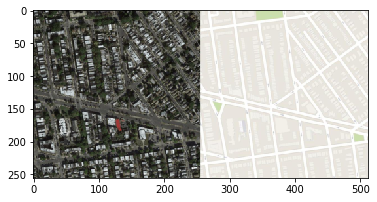

In [0]:
(image, _) = train_dataset[0]
imshow(image)

As we can see input and target are in the same image. Let's write wrapper of ImageFolder to return what we need:

In [0]:
class PhotoMapDataset(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        path, _ = self.samples[index]
        sample = self.loader(path)
        
        if self.transform is not None:
            sample = self.transform(sample)
        
        photo_image, map_image = torch.chunk(sample, chunks=2, dim=2)
        
        return photo_image, map_image

So now we have:

In [0]:
train_dataset = PhotoMapDataset(root=os.path.join(data_dir, "train"), transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

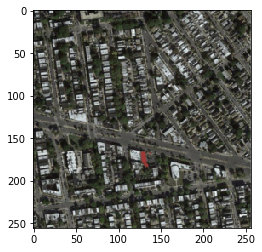

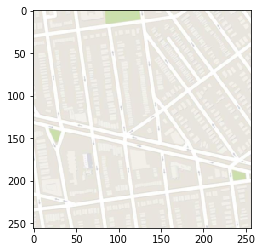

In [0]:
photo_image, map_image = train_dataset[0]
imshow(photo_image)
imshow(map_image)

Okay, we're don with data. Let's move to defining model.

## Task 2. U-Net
UNet is a very popular fully-convolutional architecture. Below you can find its structure (for more details refer to [original paper](https://arxiv.org/abs/1505.04597)):

<!-- <img src="https://github.com/karfly/learning-deep-learning/blob/master/04_dense/static/unet.png?raw=true" width=800 align="center"/> -->

<img src="https://i.imgur.com/g9niT97.png" width=800 align="center"/>

Let's build U-Net!

In [0]:
import torch
import torch.nn as nn

In [0]:
# UNetDownBlock: Conv + ReLU + Conv + ReLU + MaxPool

class UnetDownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pooling=True):
        super().__init__()
        
        # your code here
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
    def forward(self, x):
        # x: a tensor of shape (batch_size, in_channels, layer_height, layer_width)
        
        # your code here
        out_before_pooling = self.convs(x)
        out = self.maxpool(out_before_pooling)

        return out, out_before_pooling

In [0]:
# UNetUpBlock: upsampling + concat + Conv + ReLU

class UnetUpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        # your code here
        self.upsample = nn.Upsample(scale_factor=2)
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels * 2, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        
    def forward(self, x, x_bridge):
        # x: a tensor of shape (batch_size, in_channels, layer_height // 2, layer_width // 2)
        # x_bridge: a tensor of shape (batch_size, in_channels, layer_height, layer_width)
        
        # your code here
        x_up = self.upsample(x)
        x_concat = torch.cat([x_up, x_bridge], dim=1)
        out = self.convs(x_concat)
        
        return out

In [0]:
### Let's make a UNet with 5 levels and 64, 128, 256, 256, 256 channels
### (n_base_channels=64)

class Unet(nn.Module):
    def __init__(self, n_base_channels=64):
        super().__init__()
        
        # your code here
        self.down_blocks = nn.ModuleList([
            UnetDownBlock(3, n_base_channels),
            UnetDownBlock(n_base_channels, n_base_channels * 2),
            UnetDownBlock(n_base_channels * 2, n_base_channels * 4),
            UnetDownBlock(n_base_channels * 4, n_base_channels * 4),
            UnetDownBlock(n_base_channels * 4, n_base_channels * 4)
        ])
        self.up_blocks = nn.ModuleList([
            UnetUpBlock(n_base_channels * 4, n_base_channels * 4),
            UnetUpBlock(n_base_channels * 4, n_base_channels * 2),
            UnetUpBlock(n_base_channels * 2, n_base_channels),
            UnetUpBlock(n_base_channels, n_base_channels),
        ])
        self.final_block = nn.Sequential(
            #  nn.Conv2d(n_base_channels, 3, kernel_size=1, padding=0),
            nn.Conv2d(n_base_channels, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
            
        
    def forward(self, x):
        
        # your code here
        out = x
        outputs_before_pooling = []
        for i, block in enumerate(self.down_blocks):
            out, before_pooling = block(out)
            outputs_before_pooling.append(before_pooling)
            # easy mistake can be made here: for last layer, we need to save out_before_pooling
        out = before_pooling

        # now outputs_before_pooling = [block1_before_pooling, ..., block5_before_pooling]
        
        for i, block in enumerate(self.up_blocks):    # NB: it's easier to understand when using counter (i=3, etc.)
            out = block(out, outputs_before_pooling[-i - 2])
        out = self.final_block(out)
        
        return out

In [0]:
model = Unet(n_base_channels=64).to(device)

## Train-loop

Optimization setup:

In [0]:
criterion = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.0002)

Setting up SummaryWriter for TensorBoard:

In [0]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

experiment_name = "{}@{}".format(experiment_title, datetime.now().strftime("%d.%m.%Y-%H:%M:%S"))
print('experiment_name:', experiment_name)
writer = SummaryWriter(log_dir=os.path.join("./tb", experiment_name))

experiment_name: unet@27.04.2020-09:17:44


Train-loop:

In [0]:
valid_dataset = PhotoMapDataset(root=os.path.join(data_dir, "val"), transform=transform)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [0]:
n_epochs = 25

for epoch in range(n_epochs):
    model.train()
    n_iters = 0
    for batch in tqdm(train_dataloader):

        # unpack batch
        photo_image_batch, map_image_batch = batch
        photo_image_batch, map_image_batch = photo_image_batch.to(device), map_image_batch.to(device)
        
        # forward
        map_image_pred_batch = model(photo_image_batch)

        loss = criterion(map_image_pred_batch, map_image_batch)
        
        # optimize
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        # dump statistics
        writer.add_scalar("train/loss", loss.item(), global_step=epoch * len(train_dataloader) + n_iters)
        
        if n_iters % 50 == 0:
            writer.add_image('train/photo_image', torchvision.utils.make_grid(photo_image_batch) * 0.5 + 0.5, epoch * len(train_dataloader) + n_iters)
            writer.add_image('train/map_image_pred', torchvision.utils.make_grid(map_image_pred_batch), epoch * len(train_dataloader) + n_iters)
            writer.add_image('train/map_image_gt', torchvision.utils.make_grid(map_image_batch), epoch * len(train_dataloader) + n_iters)
        
        n_iters += 1
    
    # your code here
    model.eval()
    n_iters = 0
    batch_losses = []
    for batch in valid_dataloader:
        photo_image_batch, map_image_batch = batch
        photo_image_batch, map_image_batch = photo_image_batch.to(device), map_image_batch.to(device)

        map_image_pred_batch = model(photo_image_batch)

        loss = criterion(map_image_pred_batch, map_image_batch)
        batch_losses.append(loss.item())
        
        if n_iters < 5:
            writer.add_image(f'val_{n_iters}/photo_image', torchvision.utils.make_grid(photo_image_batch) * 0.5 + 0.5, 
                             epoch * len(valid_dataloader) + n_iters)
            writer.add_image(f'val_{n_iters}/map_image_pred', torchvision.utils.make_grid(map_image_pred_batch), 
                             epoch * epoch * len(valid_dataloader) + n_iters)
            writer.add_image(f'val_{n_iters}/map_image_gt', torchvision.utils.make_grid(map_image_batch), 
                             epoch * epoch * len(valid_dataloader) + n_iters)
        n_iters += 1
    
    loss_averaged = np.mean(batch_losses)
    writer.add_scalar('val/loss_averaged', loss_averaged.item(), epoch)
    
    print("Epoch {} done.".format(epoch))

  0%|          | 0/274 [00:00<?, ?it/s]

Epoch 0 done.


  0%|          | 0/274 [00:00<?, ?it/s]

Epoch 1 done.


  0%|          | 0/274 [00:00<?, ?it/s]

Epoch 2 done.


  0%|          | 0/274 [00:00<?, ?it/s]

Epoch 3 done.


  0%|          | 0/274 [00:00<?, ?it/s]

Epoch 4 done.


  0%|          | 0/274 [00:00<?, ?it/s]

Epoch 5 done.


  0%|          | 0/274 [00:00<?, ?it/s]

Epoch 6 done.


  0%|          | 0/274 [00:00<?, ?it/s]

Epoch 7 done.


  0%|          | 0/274 [00:00<?, ?it/s]

Epoch 8 done.


  0%|          | 0/274 [00:00<?, ?it/s]

Epoch 9 done.


  0%|          | 0/274 [00:00<?, ?it/s]

Epoch 10 done.


  0%|          | 0/274 [00:00<?, ?it/s]

Epoch 11 done.


  0%|          | 0/274 [00:00<?, ?it/s]

Epoch 12 done.


  0%|          | 0/274 [00:00<?, ?it/s]

Epoch 13 done.


  0%|          | 0/274 [00:00<?, ?it/s]

Epoch 14 done.


  0%|          | 0/274 [00:00<?, ?it/s]

Epoch 15 done.


  0%|          | 0/274 [00:00<?, ?it/s]

Epoch 16 done.


  0%|          | 0/274 [00:00<?, ?it/s]

Epoch 17 done.


  0%|          | 0/274 [00:00<?, ?it/s]

Epoch 18 done.


  0%|          | 0/274 [00:00<?, ?it/s]

Epoch 19 done.


  0%|          | 0/274 [00:00<?, ?it/s]

Epoch 20 done.


  0%|          | 0/274 [00:00<?, ?it/s]

Epoch 21 done.


  0%|          | 0/274 [00:00<?, ?it/s]

Epoch 22 done.


  0%|          | 0/274 [00:00<?, ?it/s]

Epoch 23 done.


100%|██████████| 274/274 [00:25<00:00, 10.92it/s]


Epoch 24 done.


### FYI

Fully-Convolutional Networks similar to the one trained today can perform extremely well for this task when segmentation losses are used, not MSELoss. If interested, check out this: https://www.youtube.com/watch?v=yUyaYL_x4kQ